# 优化器

## PyTorch提供的优化器
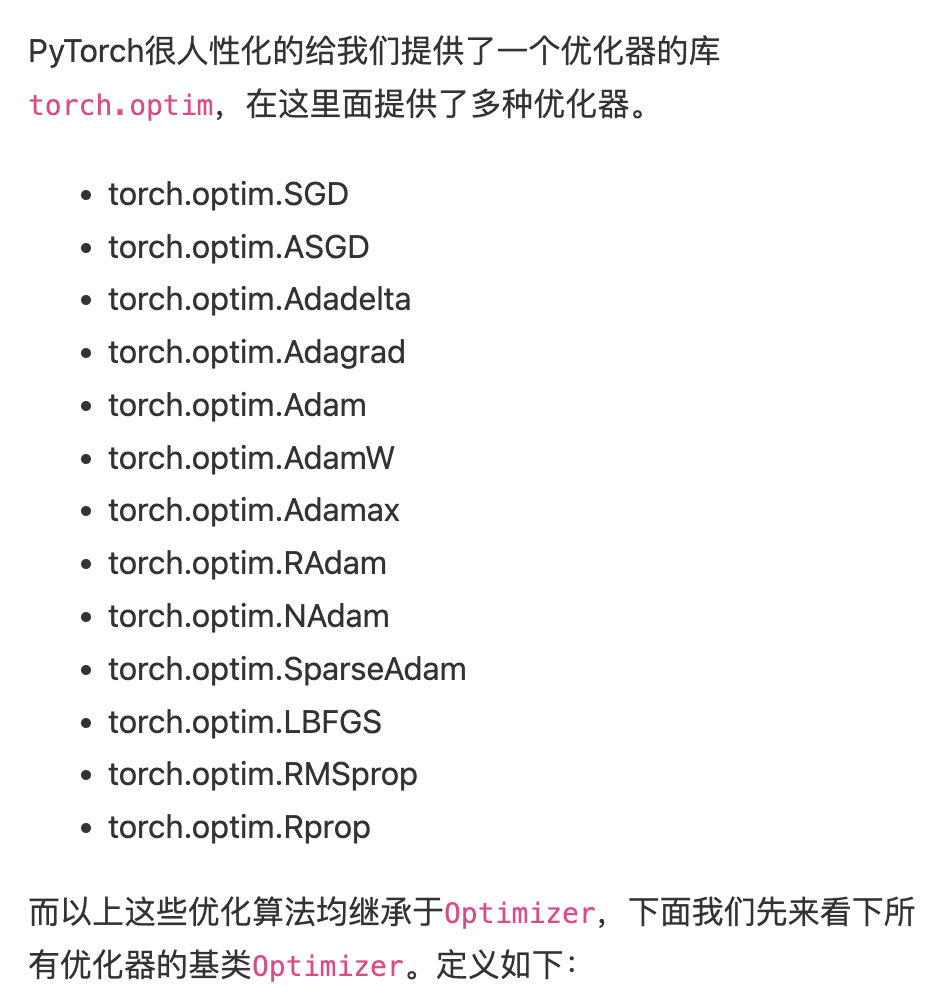

以上这些优化算法均继承于Optimizer，下面我们先来看下所有优化器的基类Optimizer

In [1]:
class Optimizer(object):
    def __init__(self, params, defaults):        
        self.defaults = defaults
        self.state = defaultdict(dict)
        self.param_groups = []

Optimizer有三个属性：

- defaults：存储的是优化器的超参数，例子如下：
    - {'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}
- state：参数的缓存，例子如下：
    - defaultdict(<class 'dict'>, {tensor([[ 0.3864, -0.0131],
        [-0.1911, -0.4511]], requires_grad=True): {'momentum_buffer': tensor([[0.0052, 0.0052],
        [0.0052, 0.0052]])}})
- param_groups：管理的参数组，是一个list，其中每个元素是一个字典，顺序是params，lr，momentum，dampening，weight_decay，nesterov，例子如下：
    - [{'params': [tensor([[-0.1022, -1.6890],[-1.5116, -1.7846]], requires_grad=True)], 'lr': 1, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]


Optimizer还有以下的方法：
- zero_grad()：清空所管理参数的梯度，PyTorch的特性是张量的梯度不自动清零，因此每次反向传播后都需要清空梯度。
```
def zero_grad(self, set_to_none: bool = False):
    for group in self.param_groups:
        for p in group['params']:
            if p.grad is not None:  #梯度不为空
                if set_to_none: 
                    p.grad = None
                else:
                    if p.grad.grad_fn is not None:
                        p.grad.detach_()
                    else:
                        p.grad.requires_grad_(False)
                    p.grad.zero_()# 梯度设置为0
```
- step()：执行一步梯度更新，参数更新
```
def step(self, closure): 
    raise NotImplementedError
```
- add_param_group()：添加参数组
```
def add_param_group(self, param_group):
    assert isinstance(param_group, dict), "param group must be a dict"
# 检查类型是否为tensor
    params = param_group['params']
    if isinstance(params, torch.Tensor):
        param_group['params'] = [params]
    elif isinstance(params, set):
        raise TypeError('optimizer parameters need to be organized in ordered collections, but '
                        'the ordering of tensors in sets will change between runs. Please use a list instead.')
    else:
        param_group['params'] = list(params)
    for param in param_group['params']:
        if not isinstance(param, torch.Tensor):
            raise TypeError("optimizer can only optimize Tensors, "
                            "but one of the params is " + torch.typename(param))
        if not param.is_leaf:
            raise ValueError("can't optimize a non-leaf Tensor")

    for name, default in self.defaults.items():
        if default is required and name not in param_group:
            raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                             name)
        else:
            param_group.setdefault(name, default)

    params = param_group['params']
    if len(params) != len(set(params)):
        warnings.warn("optimizer contains a parameter group with duplicate parameters; "
                      "in future, this will cause an error; "
                      "see github.com/PyTorch/PyTorch/issues/40967 for more information", stacklevel=3)
# 上面好像都在进行一些类的检测，报Warning和Error
    param_set = set()
    for group in self.param_groups:
        param_set.update(set(group['params']))

    if not param_set.isdisjoint(set(param_group['params'])):
        raise ValueError("some parameters appear in more than one parameter group")
# 添加参数
    self.param_groups.append(param_group)
```
- load_state_dict() ：加载状态参数字典，可以用来进行模型的断点续训练，继续上次的参数进行训练
```
def load_state_dict(self, state_dict):
    r"""Loads the optimizer state.

    Arguments:
        state_dict (dict): optimizer state. Should be an object returned
            from a call to :meth:`state_dict`.
    """
    # deepcopy, to be consistent with module API
    state_dict = deepcopy(state_dict)
    # Validate the state_dict
    groups = self.param_groups
    saved_groups = state_dict['param_groups']

    if len(groups) != len(saved_groups):
        raise ValueError("loaded state dict has a different number of "
                         "parameter groups")
    param_lens = (len(g['params']) for g in groups)
    saved_lens = (len(g['params']) for g in saved_groups)
    if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
        raise ValueError("loaded state dict contains a parameter group "
                         "that doesn't match the size of optimizer's group")

    # Update the state
    id_map = {old_id: p for old_id, p in
              zip(chain.from_iterable((g['params'] for g in saved_groups)),
                  chain.from_iterable((g['params'] for g in groups)))}

    def cast(param, value):
        r"""Make a deep copy of value, casting all tensors to device of param."""
   		.....

    # Copy state assigned to params (and cast tensors to appropriate types).
    # State that is not assigned to params is copied as is (needed for
    # backward compatibility).
    state = defaultdict(dict)
    for k, v in state_dict['state'].items():
        if k in id_map:
            param = id_map[k]
            state[param] = cast(param, v)
        else:
            state[k] = v

    # Update parameter groups, setting their 'params' value
    def update_group(group, new_group):
       ...
    param_groups = [
        update_group(g, ng) for g, ng in zip(groups, saved_groups)]
    self.__setstate__({'state': state, 'param_groups': param_groups})
```
- state_dict()：获取优化器当前状态信息字典
```
def state_dict(self):
    r"""Returns the state of the optimizer as a :class:`dict`.

    It contains two entries:

    * state - a dict holding current optimization state. Its content
        differs between optimizer classes.
    * param_groups - a dict containing all parameter groups
    """
    # Save order indices instead of Tensors
    param_mappings = {}
    start_index = 0

    def pack_group(group):
		......
    param_groups = [pack_group(g) for g in self.param_groups]
    # Remap state to use order indices as keys
    packed_state = {(param_mappings[id(k)] if isinstance(k, torch.Tensor) else k): v
                    for k, v in self.state.items()}
    return {
        'state': packed_state,
        'param_groups': param_groups,
    }
```

## 实际操作

In [3]:
import os
import torch

# 设置权重，服从正态分布  --> 2 x 2
weight = torch.randn((2, 2), requires_grad=True)
# 设置梯度为全1矩阵  --> 2 x 2
weight.grad = torch.ones((2, 2))
# 输出现有的weight和data
print("The data of weight before step:\n{}".format(weight.data))
print("The grad of weight before step:\n{}".format(weight.grad))
# 实例化优化器
optimizer = torch.optim.SGD([weight], lr=0.1, momentum=0.9)
# 进行一步操作
optimizer.step()
# 查看进行一步后的值，梯度
print("The data of weight after step:\n{}".format(weight.data))
print("The grad of weight after step:\n{}".format(weight.grad))
# 权重清零
optimizer.zero_grad()
# 检验权重是否为0
print("The grad of weight after optimizer.zero_grad():\n{}".format(weight.grad))
# 输出参数
print("optimizer.params_group is \n{}".format(optimizer.param_groups))
# 查看参数位置，optimizer和weight的位置一样，我觉得这里可以参考Python是基于值管理
print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))
# 添加参数：weight2
weight2 = torch.randn((3, 3), requires_grad=True)
optimizer.add_param_group({"params": weight2, 'lr': 0.0001, 'nesterov': True})
# 查看现有的参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
# 查看当前状态信息
opt_state_dict = optimizer.state_dict()
print("state_dict before step:\n", opt_state_dict)
# 进行5次step操作
for _ in range(50):
    optimizer.step()
# 输出现有状态信息
print("state_dict after step:\n", optimizer.state_dict())
# 保存参数信息
torch.save(optimizer.state_dict(),os.path.join("./", "optimizer_state_dict.pkl"))
print("----------done-----------")
# 加载参数信息
state_dict = torch.load("./optimizer_state_dict.pkl") # 需要修改为你自己的路径
optimizer.load_state_dict(state_dict)
print("load state_dict successfully\n{}".format(state_dict))
# 输出最后属性信息
print("\n{}".format(optimizer.defaults))
print("\n{}".format(optimizer.state))
print("\n{}".format(optimizer.param_groups))

The data of weight before step:
tensor([[-0.1213, -1.8836],
        [ 1.9863,  0.4806]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])
The data of weight after step:
tensor([[-0.2213, -1.9836],
        [ 1.8863,  0.3806]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])
The grad of weight after optimizer.zero_grad():
None
optimizer.params_group is 
[{'params': [tensor([[-0.2213, -1.9836],
        [ 1.8863,  0.3806]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False}]
weight in optimizer:5188180208
weight in weight:5188180208

optimizer.param_groups is
[{'params': [tensor([[-0.2213, -1.9836],
        [ 1.8863,  0.3806]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False}, {'params': [tensor([[ 1.3839,  2.3943, -1.3146],

### 注意

1. 每个优化器都是一个类，我们一定要进行实例化才能使用

In [ ]:
class Net(nn.Moddule):
    ···
net = Net()
optim = torch.optim.SGD(net.parameters(),lr=lr)
optim.step()

2. optimizer在一个神经网络的epoch中需要实现下面两个步骤：
- 梯度置零
- 梯度更新

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-5)
for epoch in range(EPOCH):
	...
	optimizer.zero_grad()  #梯度置零
	loss = ...             #计算loss
	loss.backward()        #BP反向传播
	optimizer.step()       #梯度更新

3. 给网络不同的层赋予不同的优化器参数

In [ ]:
from torch import optim
from torchvision.models import resnet18

net = resnet18()

optimizer = optim.SGD([
    {'params':net.fc.parameters()},#fc的lr使用默认的1e-5
    {'params':net.layer4[0].conv1.parameters(),'lr':1e-2}],lr=1e-5)

# 可以使用param_groups查看属性